In [14]:
import nibabel as nib
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.measure import label, regionprops
from matplotlib.patches import Rectangle
from scipy.ndimage import binary_erosion, label

from pathlib import Path

# Load the CT scan
ct_file_path = Path("..") / "data" / "segthor_train" / "train" / "Patient_01" / "Patient_01.nii.gz"
ct_image = nib.load(ct_file_path)
ct_data = ct_image.get_fdata()

# Load the ground truth segmentation
gt_file_path = Path("..") / "data" / "segthor_train" / "train" / "Patient_01" / "GT.nii.gz"
gt_image = nib.load(gt_file_path)
gt_data = gt_image.get_fdata()


In [20]:
# Get voxel dimensions (pixel spacing) after reorientation
dx, dy, dz = ct_image.header.get_zooms()
print(f"Voxel dimensions (dx, dy, dz): {dx}, {dy}, {dz} mm")

Pixel spacing (dx): 0.9765625 mm


In [16]:
# Calculate Transverse Diameters of Heart

num_slices = ct_data.shape[2]
heart_diameters = np.zeros(num_slices)

for slice_number in range(num_slices):
    # Heart segmentation for the current slice
    heart_slice = gt_data[:, :, slice_number]
    heart_mask = (heart_slice == 2)  # Heart label is 2

    # Calculate heart transverse diameter if heart is present in the slice
    if np.any(heart_mask):
        x_indices = np.where(np.any(heart_mask, axis=0))[0]
        if x_indices.size > 0:
            left_heart = x_indices.min()
            right_heart = x_indices.max()
            heart_diameter = (right_heart - left_heart + 1) * dx
            heart_diameters[slice_number] = heart_diameter

# Identify the slice with the maximum heart diameter
max_heart_slice = np.argmax(heart_diameters)
max_heart_diameter = heart_diameters[max_heart_slice]
print(f"Slice with maximum heart diameter: {max_heart_slice}")
print(f"Maximum heart diameter: {max_heart_diameter:.2f} mm")

Slice with maximum heart diameter: 85
Maximum heart diameter: 121.09 mm


In [17]:
# Select the slice with the maximum heart diameter
slice_number = max_heart_slice

# Extract the CT slice
ct_slice = ct_data[:, :, slice_number]

# Thresholding to segment the body
body_threshold = -300  # Threshold to separate body from air
body_mask = ct_slice > body_threshold

# Remove small objects and keep the largest connected component
body_mask = morphology.remove_small_objects(body_mask.astype(bool), min_size=500)
labeled_mask = measure.label(body_mask)
regions = measure.regionprops(labeled_mask)

if regions:
    # Assuming the largest area is the thorax
    body_region = max(regions, key=lambda x: x.area)
    body_mask = labeled_mask == body_region.label

# Calculate the transverse diameter of the thorax (largest connected component)
x_indices = np.where(np.any(body_mask, axis=0))[0]
if x_indices.size > 0:
    left_inner_edge = x_indices.min()
    right_inner_edge = x_indices.max()
    thoracic_diameter = (right_inner_edge - left_inner_edge + 1) * dx
    print(f"Thoracic diameter on slice {slice_number}: {thoracic_diameter:.2f} mm")
else:
    thoracic_diameter = 0
    print("Unable to determine thoracic diameter from body mask.")

Thoracic diameter on slice 85: 275.39 mm


In [18]:
# Ensure both diameters are available
if max_heart_diameter > 0 and thoracic_diameter > 0:
    # Calculate the cardiothoracic ratio
    ctr = max_heart_diameter / thoracic_diameter
    print(f"Cardiothoracic ratio (CTR): {ctr:.2f}")

    # Determine if CTR is higher than 0.5
    is_cardiomegaly = ctr > 0.5
    print(f"Is cardiomegaly present (CTR > 0.5)? {is_cardiomegaly}")
else:
    print("Unable to calculate CTR due to missing diameters.")



Cardiothoracic ratio (CTR): 0.44
Is cardiomegaly present (CTR > 0.5)? False


C:\Users\alelj\AppData\Local\Temp\ipykernel_17620\3131712001.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(body_mask.T, colors='green', linewidths=1, label='Thorax Boundary')


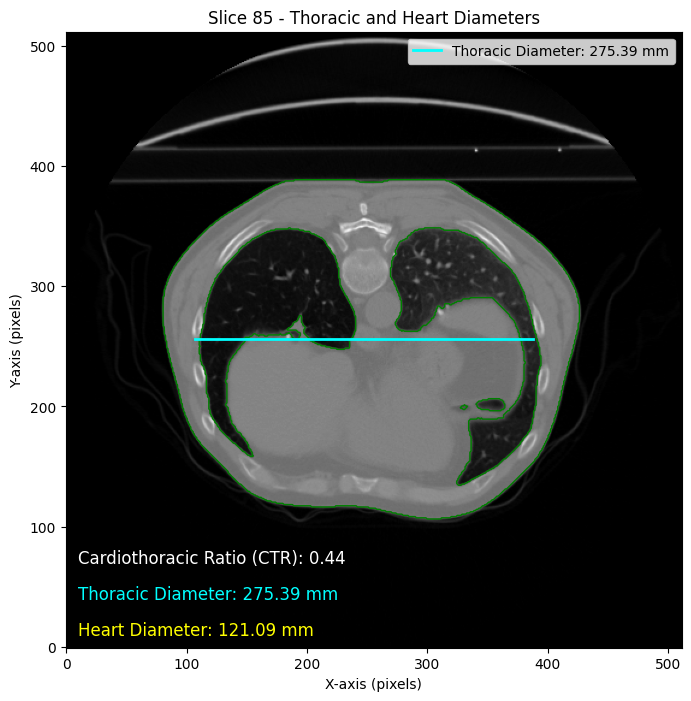

In [19]:
# Visualize the Segmentation of the Thorax with Inner Diameter

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ct_slice.T, cmap='gray', origin='lower')

# Draw borders of the largest connected component (thorax)
ax.contour(body_mask.T, colors='green', linewidths=1, label='Thorax Boundary')

# Draw thoracic diameter line
ax.plot([left_inner_edge, right_inner_edge], [ct_slice.shape[1] // 2, ct_slice.shape[1] // 2],
        color='cyan', linewidth=2, label=f'Thoracic Diameter: {thoracic_diameter:.2f} mm')

# Add legend and labels
ax.set_title(f'Slice {slice_number} - Thoracic and Heart Diameters')
ax.set_xlabel('X-axis (pixels)')
ax.set_ylabel('Y-axis (pixels)')
ax.legend(loc='upper right')

# Add text annotations for diameters and CTR
ax.text(10, 10, f'Heart Diameter: {max_heart_diameter:.2f} mm', color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax.text(10, 40, f'Thoracic Diameter: {thoracic_diameter:.2f} mm', color='cyan', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax.text(10, 70, f'Cardiothoracic Ratio (CTR): {ctr:.2f}', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()